# Models: Collaborative Denoising Auto Encoder

* [Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)
* [Deep AutoEncoders for Collaborative Filtering](https://github.com/marlesson/recsys_autoencoders#2-cdae---collaborative-denoising-auto-encoders-for-top-n-recommender-systems)
* [K-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problemK-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problem](https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29)

In [1]:
%load_ext autoreload
%autoreload 2
BASE_PATH      = '../..'
DATASETS_PATH  = f'{BASE_PATH}/datasets'
EMBEDDING_PATH = f'{DATASETS_PATH}/caa_user_ratings_embedings.json'

In [2]:
import sys
sys.path.append(f'{BASE_PATH}/lib')

In [3]:
import pytorch_common
pytorch_common.__version__

'0.0.23'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

import numpy as np
import pandas as pd
from bunch import Bunch


import torch
from torch.nn import Sigmoid, ReLU, BCELoss, MSELoss
from torch.utils.data import DataLoader
from torch.optim      import Adam

import pytorch_common.util as pu
from pytorch_common.callbacks.output import (
    Logger,
    MetricsPlotter
)
from pytorch_common.util import (
    set_device_name,
    get_device,
    LoggerBuilder
)

import model as ml

import data.dataset as ds
import data.plot as pl
import data as dt

import logging
import random

import util as ut

2023-04-03 08:44:44.785473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('cpu')

pu.get_device(), torch.cuda.is_available(), torch.__version__

(device(type='cpu'), True, '1.11.0')

In [7]:
cpu = pu.set_device_name('cpu')

In [8]:
ut.set_seed(42)

## Helper Functions

In [9]:
def save_df(df, path): return df.to_json  (path, orient='records')
def load_df(path):     return pd.read_json(path, orient='records')

In [10]:
def build_user_ratings_df(latent_space, dataset):
    user_ratings_emb_df = pd.DataFrame({
        'user_ratings_emb': [latent_space[idx] for idx in range(latent_space.shape[0])],
        'cluster': medoids_result.labels
    })
    user_ratings_emb_df['user_seq'] = user_ratings_emb_df.index
    
    id_by_seq_dict = ut.id_by_seq(dataset, 'user')
    user_ratings_emb_df['user_id']  = user_ratings_emb_df['user_seq'].apply(lambda seq: id_by_seq_dict[seq])
    return user_ratings_emb_df

In [11]:
def get_groups(df, group_cols):
    df = df.explode(group_cols[-1])
    
    if 'movie_genres' in group_cols:
        df = df[df['movie_genres'] != '(no genres listed)']
    
    df = df.groupby(group_cols)[group_cols[-1]].count()
    df = pd.DataFrame(df)
    df = df.rename(columns={group_cols[-1]:'count'})
    df = df.reset_index()
    df = df.sort_values(group_cols)
    return df

def swap_groups(df):
    columns = list(reversed([c for c in df.columns if c != 'count']))    
    return df.groupby(columns).sum().reset_index()

def norm(df, group_cols, norm_col='count'):
    groups = df.groupby(group_cols, group_keys=False)
    df[norm_col] = groups[norm_col].apply(lambda x: x / x.sum())
    return df

In [12]:
def div_bar_plot(df, x, hue, alpha=0.7, height=6, width=0.8, aspect=4.5):
    sns.set_style('whitegrid')
    sns.catplot(
        x      = x,
        y      = 'count',
        hue    = hue,
        data   = df,
        kind   = 'bar',
        alpha  = alpha,
        height = height,
        width  = width,
        aspect = aspect
    )

## Carga de dataset

In [13]:
dataset  = ds.MovieLensTMDBDatasetFactory.df_from_path(f'{BASE_PATH}/datasets')

In [14]:
train_ds = ds.CollaborativeDenoiseAutoEncoderDataset(dataset)

In [15]:
movies_count = dataset.movie_seq.max() + 1
users_count  = dataset.user_seq.max() + 1

users_count, movies_count

(1885, 17611)

## Entrenamiento

In [331]:
params = Bunch({
    'lr'               : 0.000001,
    'epochs'           : 40,
    'latent_space_dim' : 3,
    'n_workers'        : 24,
    'batch_size'       : 128,
    'noise_dropout'    : 0.2,
    'train'            : True
})

In [309]:
train_dl = DataLoader(
    train_ds, 
    batch_size  = params.batch_size,
    num_workers = params.n_workers,
    pin_memory  = True,
    shuffle     = True
)

In [310]:
model = ml.CollaborativeDenoisingAutoEncoder(
    n_users                      = users_count,
    n_item_ratings               = movies_count,
    latent_space_dim             = params.latent_space_dim,
    encoder_activation           = ReLU(),
    encoder_noise_dropout        = params.noise_dropout
).to(pu.get_device())
model

CollaborativeDenoisingAutoEncoder(
  (encoder): CollaborativeDenoisingEncoder(
    (users_embedding): Embedding(1885, 3)
    (noise_layer): Dropout(p=0.2, inplace=False)
    (items_ratings_mlp): Linear(in_features=17611, out_features=3, bias=True)
    (mlp): MultiLayerPerceptron(
      (mlp): Sequential(
        (0): Linear(in_features=17611, out_features=3, bias=True)
        (1): ReLU()
      )
    )
  )
  (decoder): CollaborativeDecoder(
    (mlp): MultiLayerPerceptron(
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=17611, bias=True)
        (1): ReLU()
      )
    )
  )
)

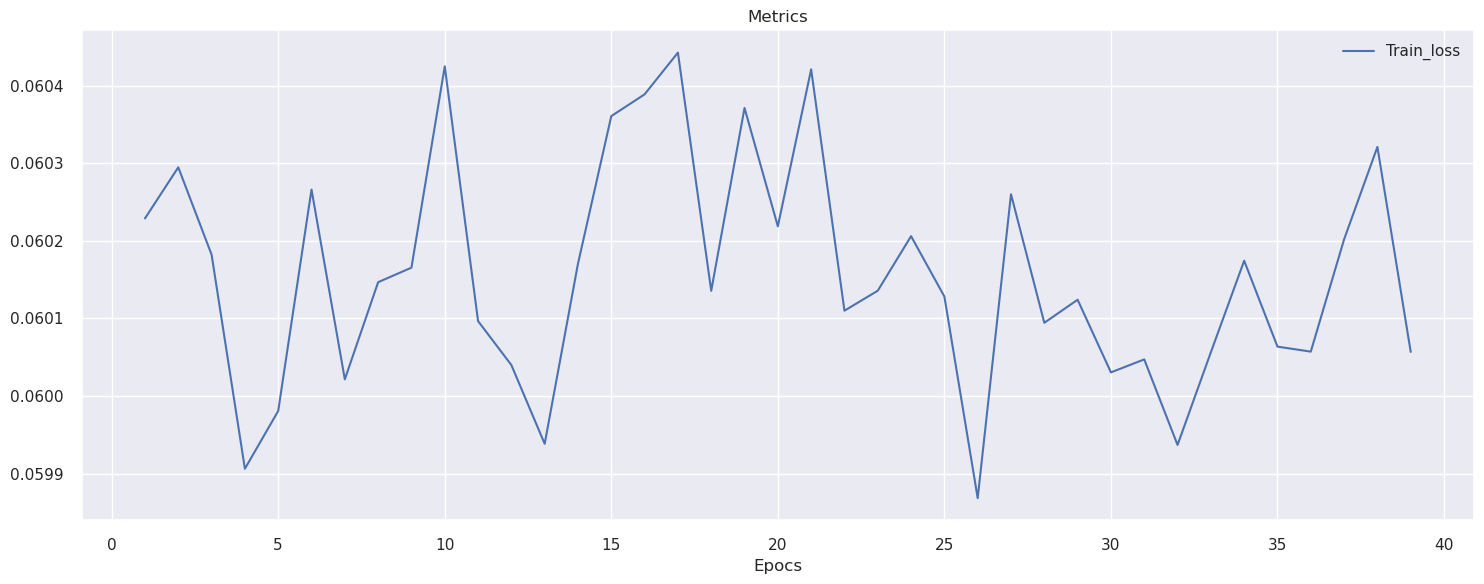

0.059958315640687945

In [332]:
if params.train:
    optimizer   = Adam(
        params = model.parameters(),
        lr     = params.lr
    )
    callbacks = [
        Logger(['time', 'epoch', 'train_loss']),
        MetricsPlotter(
            metrics            = ['train_loss'],
            plot_each_n_epochs = 1,
            reg_each_n_epochs  = 1
        )
    ]
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = MSELoss(),
        optimizer   = optimizer,
        callbacks  = callbacks
    )
    print(result.train_loss)
    model.save('cae-checkpoint') if params.train else model.load('cae-checkpoint')

## Analisis de clusters de usuarios a partir de sus embeddings

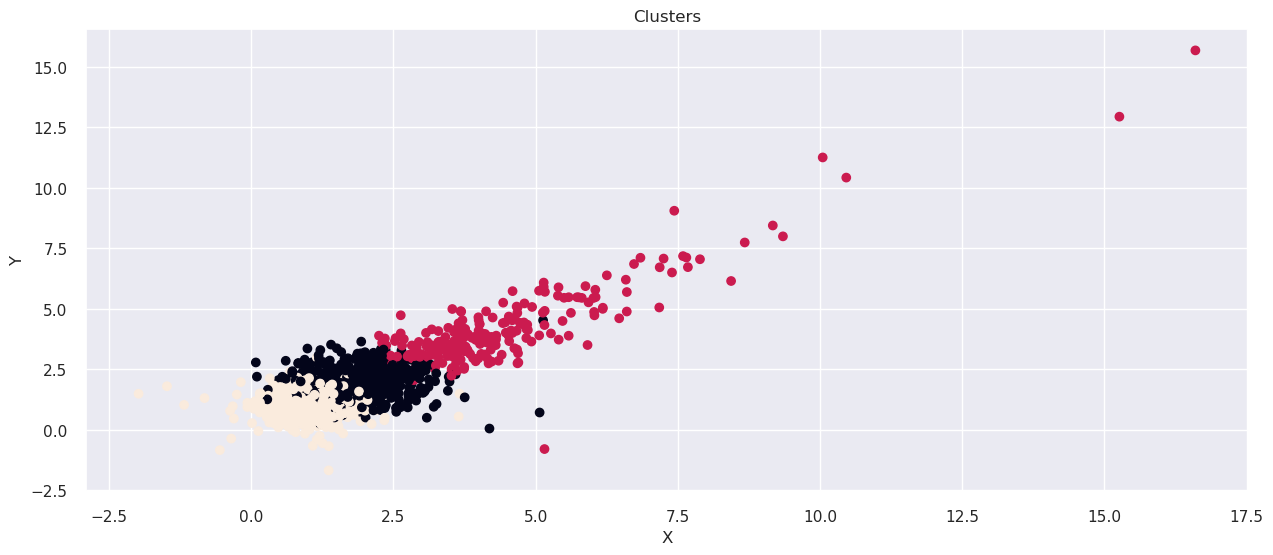

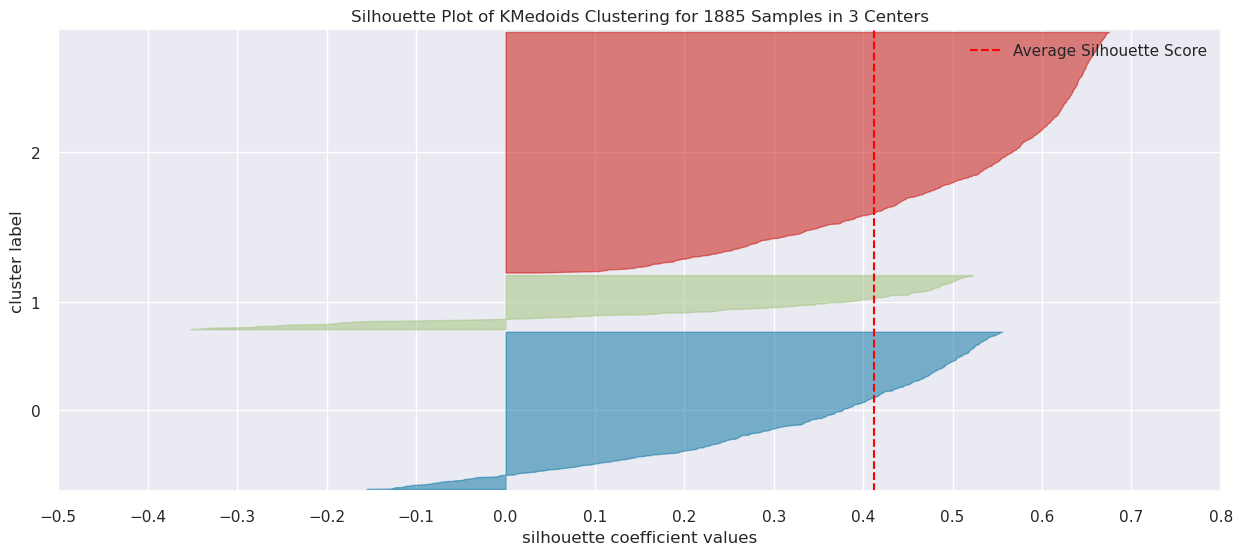

Silhouette: -0.37129896879196167


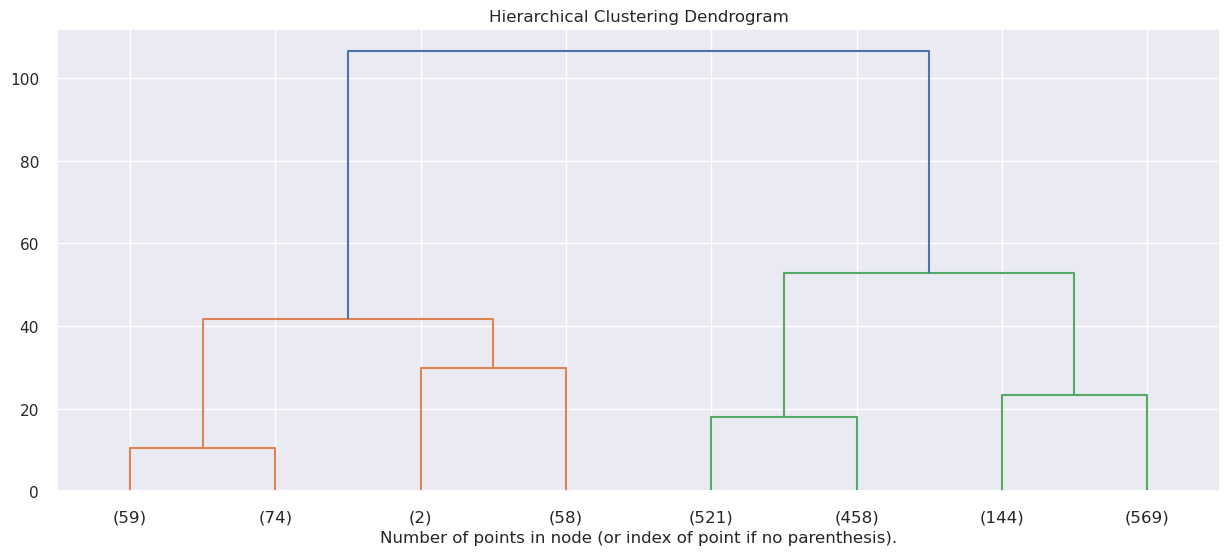

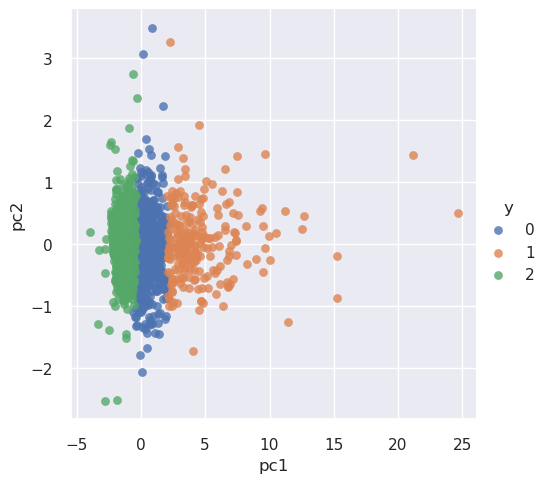

2023-04-03 19:52:23,463 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


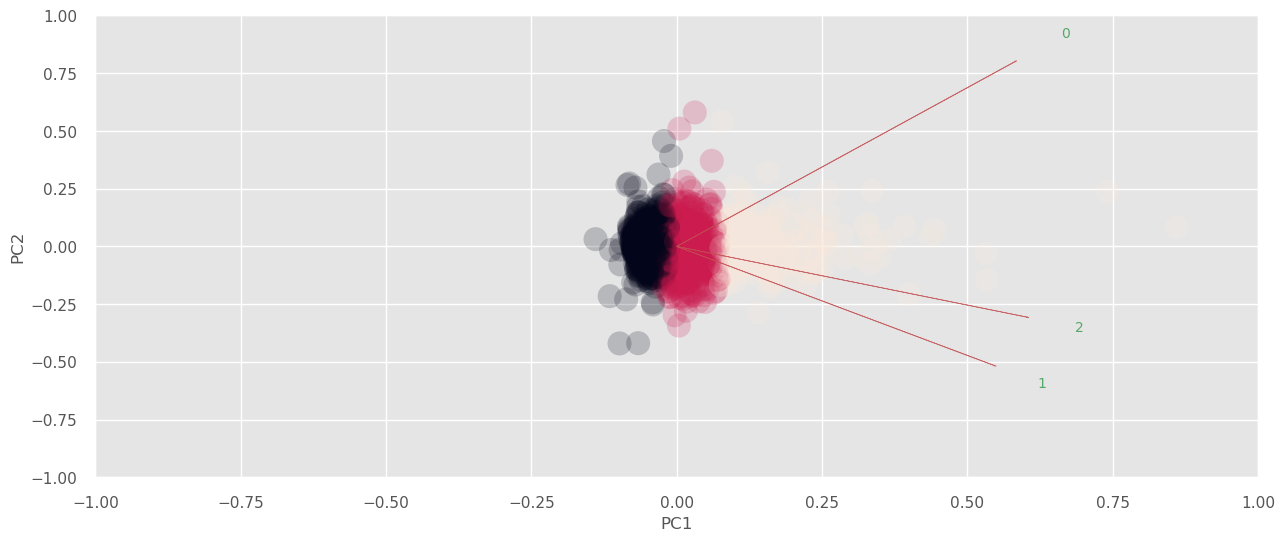

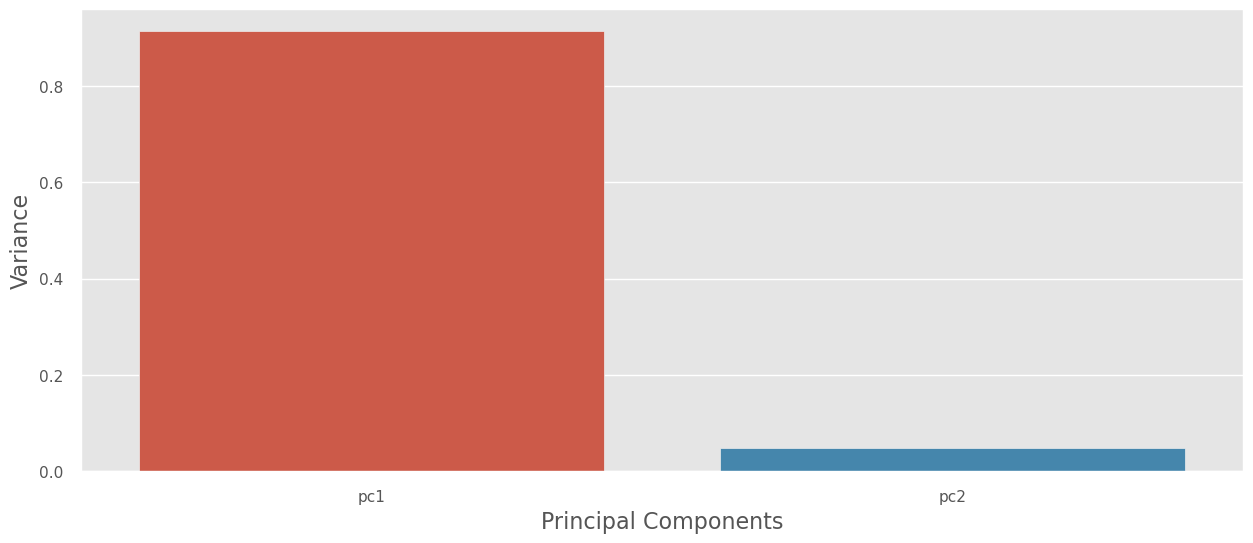

array([0.91323584, 0.0481117 ], dtype=float32)

In [333]:
latent_space = model.as_encoder()(train_ds)

medoids_result = ml.KMedoisClustering(n_clusters = 3) \
    .predict(latent_space) \
    .plot()


pl.plot_dendrogram(latent_space, max_top_levels=2)

dt.PCAAnalisys \
    .make_on(
        X = pd.DataFrame(latent_space),
        y = medoids_result.labels,
        n_components = 2
    ) \
    .plot()


In [334]:
user_ratings_emb_df = build_user_ratings_df(latent_space, dataset)

save_df(user_ratings_emb_df, EMBEDDING_PATH)

In [335]:
user_ratings_emb_df = load_df(EMBEDDING_PATH)

user_ratings_emb_df.head()

,user_ratings_emb,cluster,user_seq,user_id
0,"[1.3034940958, 2.0220906734, 0.4887535572]",2,0,791
1,"[2.4547605515, 2.2827272415, 2.0073165894]",0,1,3164
2,"[7.8903541565, 7.0409021378, 8.4603347778]",1,2,3448
3,"[2.1058101654, 1.6825426817, 2.0528826714]",0,3,4676
4,"[0.9519241452, 1.0929377079, 0.6627035737]",2,4,4693


## Analisis de peliculas vistas en cada cluster de usuarios

In [336]:
dataset['release_decade'] = dataset['movie_release_year'].apply(lambda year: (year//10)*10 )

In [337]:
data1 = dataset.merge(user_ratings_emb_df, on=['user_seq'])

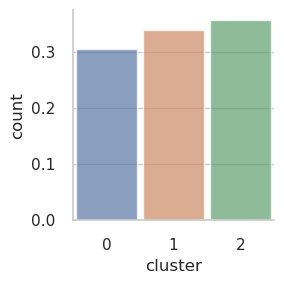

In [338]:
df = data1.pipe(get_groups, group_cols=['cluster'])
df['count'] = df['count'] / df['count'].sum()

div_bar_plot(
    df,
    x='cluster',
    hue=None,
    aspect = 1, height=3, width=0.9
)

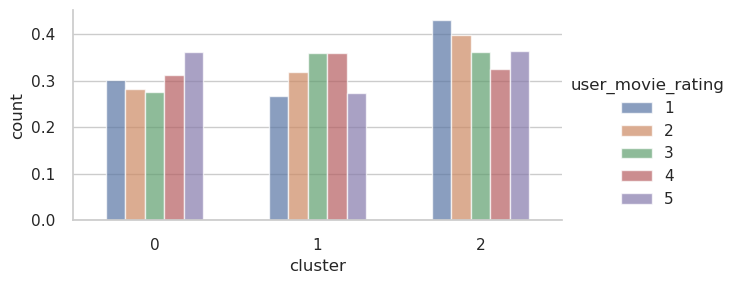

In [339]:
df = data1 \
    .pipe(get_groups, group_cols=['cluster', 'user_movie_rating']) \
    .pipe(norm, group_cols='user_movie_rating', norm_col='count') \
   
div_bar_plot(
    df,
    x='cluster',
    hue='user_movie_rating',
    aspect = 2, height=3, width=0.6
)

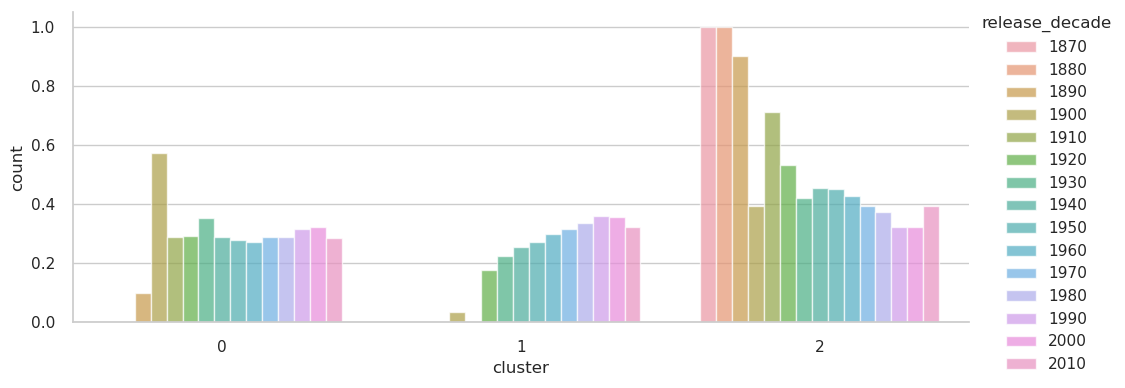

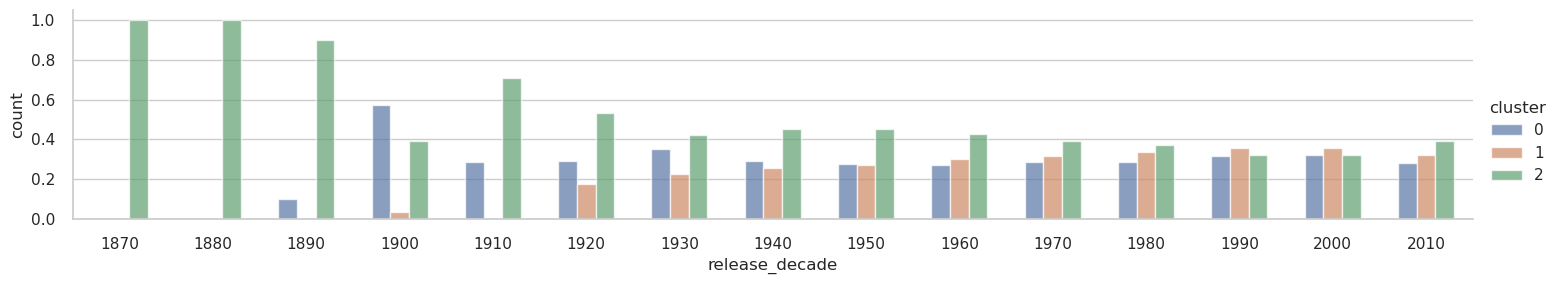

In [340]:
df = data1 \
    .pipe(get_groups, group_cols=['cluster', 'release_decade']) \
    .pipe(norm, group_cols='release_decade', norm_col='count')

div_bar_plot(
    df,
    x='cluster',
    hue='release_decade',
    aspect = 2.5, height=4
)

div_bar_plot(
    df,
    x='release_decade',
    hue='cluster',
    aspect = 5, height=3, width=0.6
)

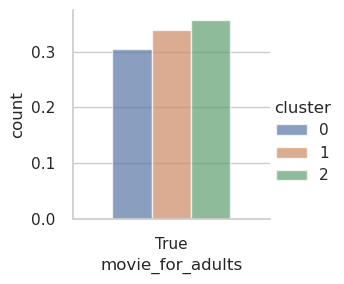

In [341]:
df = data1.pipe(get_groups, group_cols=['cluster', 'movie_for_adults'])

div_bar_plot(
    df.pipe(norm, group_cols='movie_for_adults', norm_col='count'),
    x='movie_for_adults',
    hue='cluster',
    aspect = 1, height=3, width=0.6
)

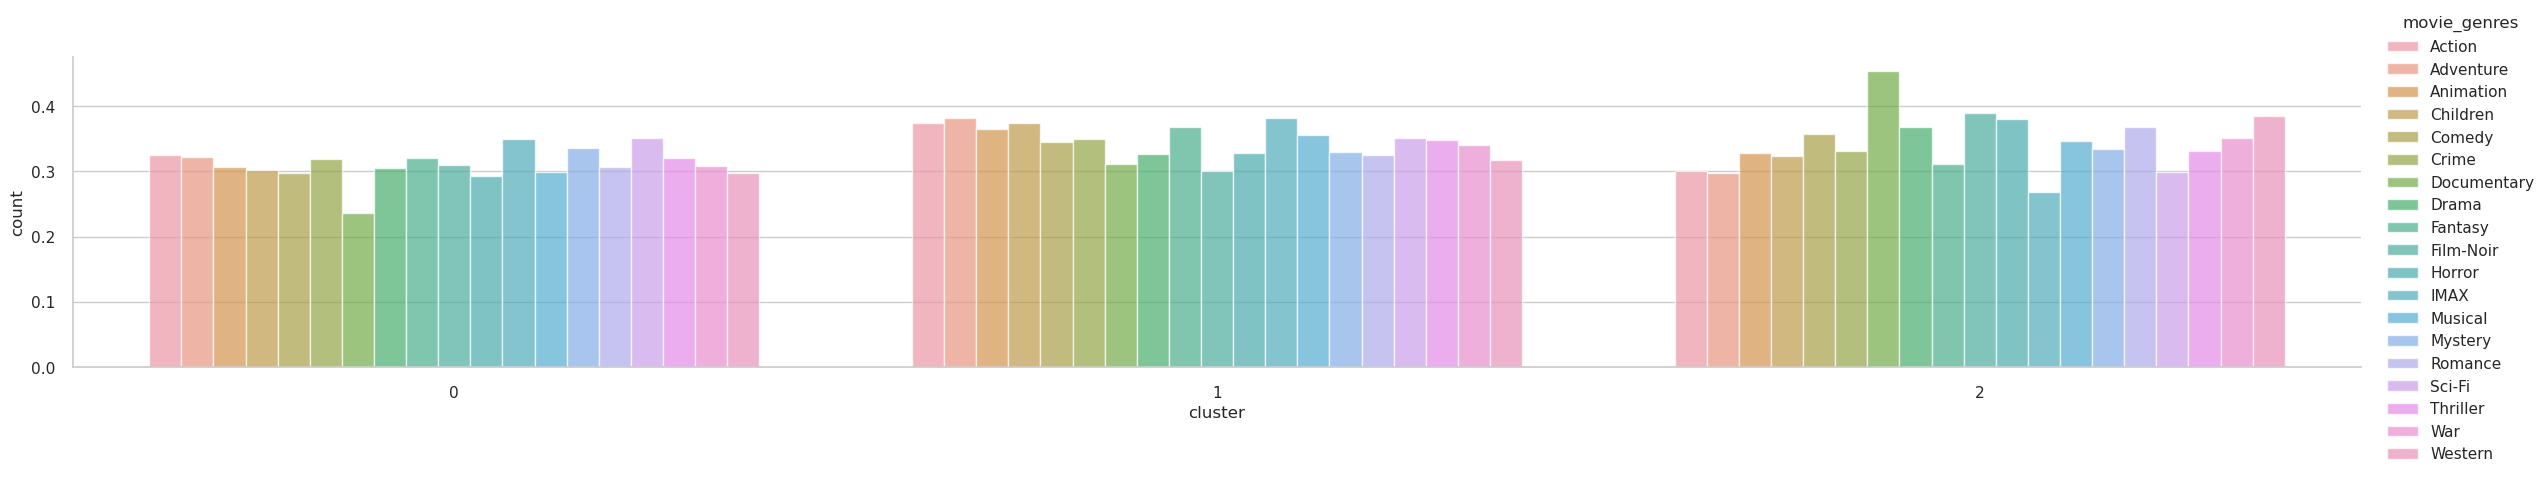

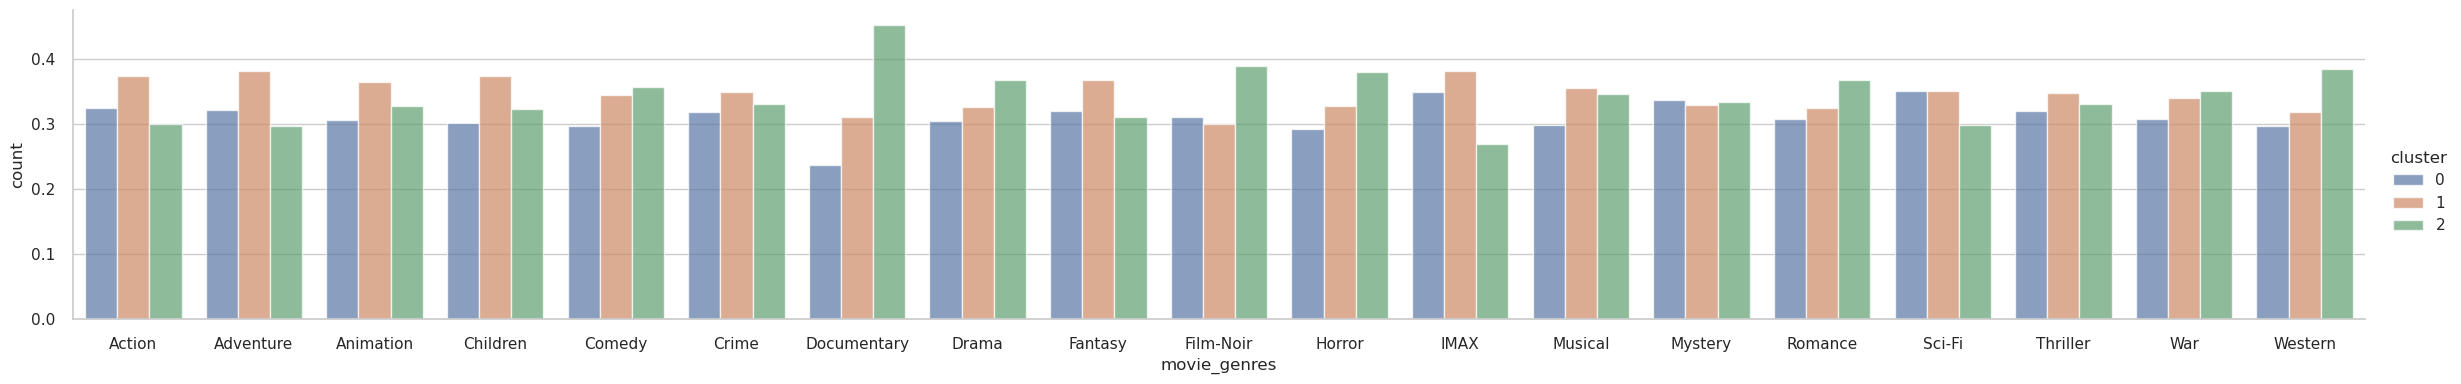

In [342]:
df = data1 \
    .pipe(get_groups, group_cols=['cluster', 'movie_genres']) \
    .pipe(norm, group_cols='movie_genres', norm_col='count')

div_bar_plot(
    df,
    x='cluster',
    hue='movie_genres',
    height = 4,
    aspect = 6
)

div_bar_plot(
    df,
    x='movie_genres',
    hue='cluster',
    height = 4,
    aspect = 6
)

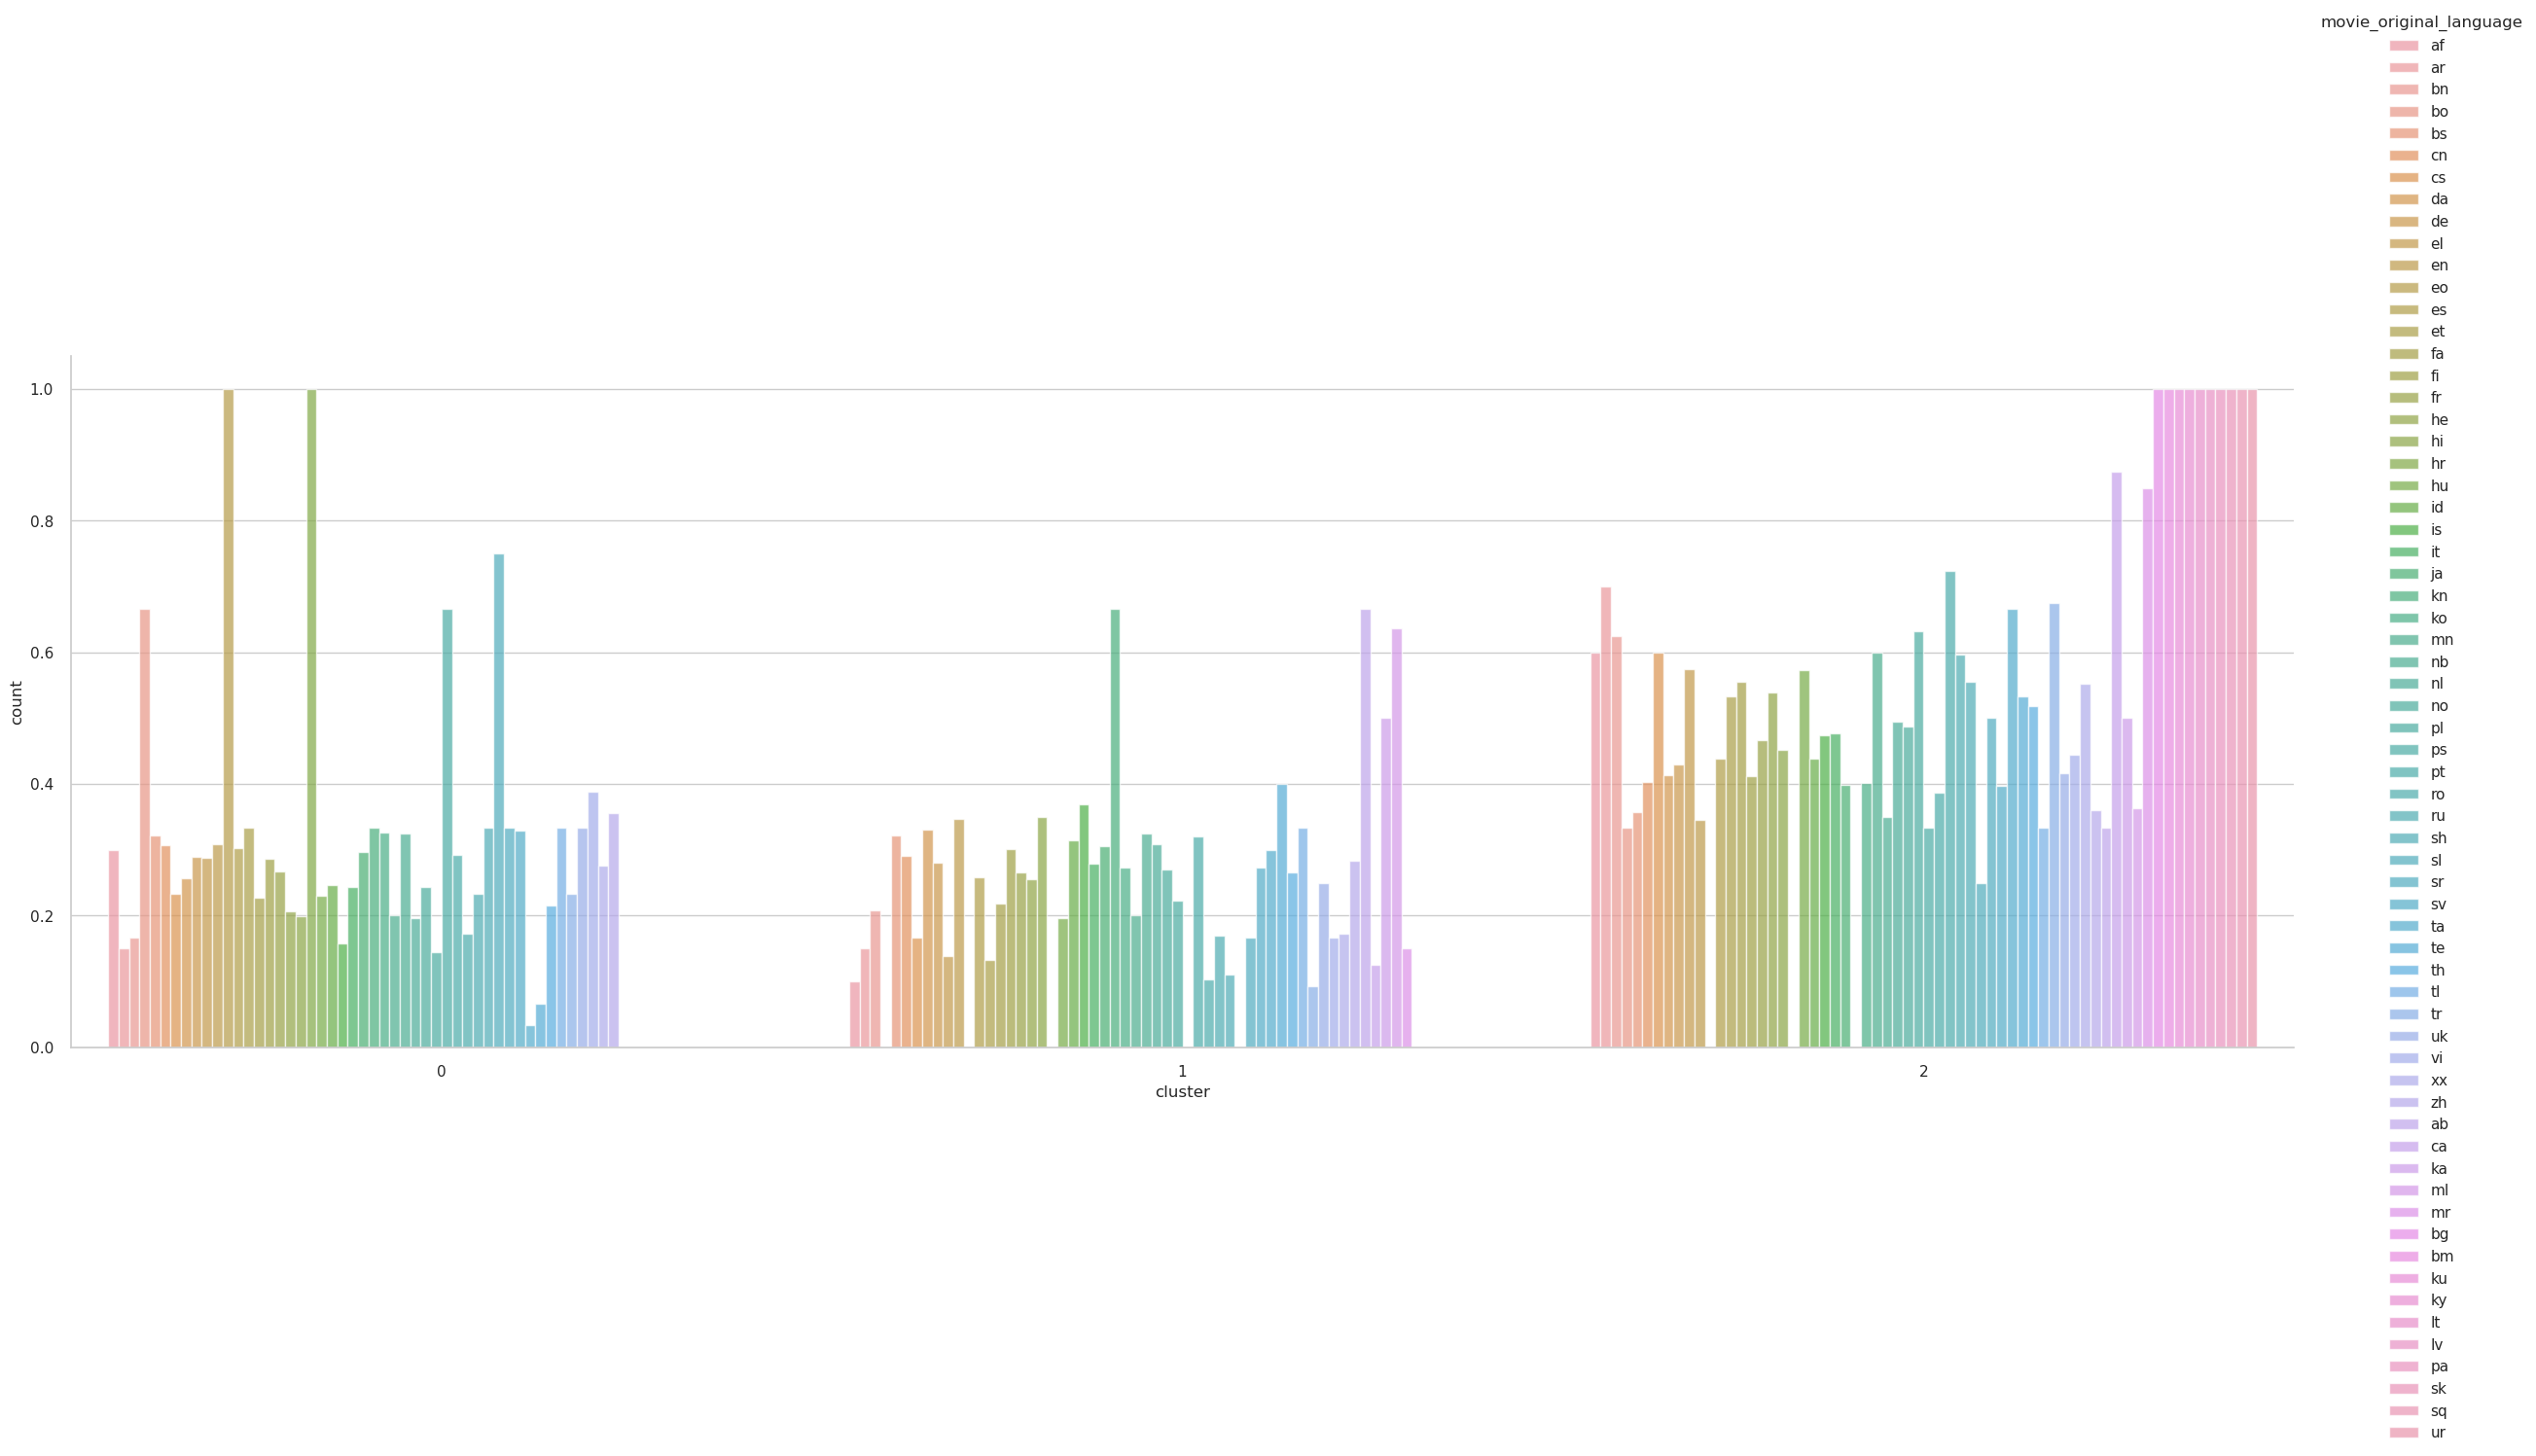

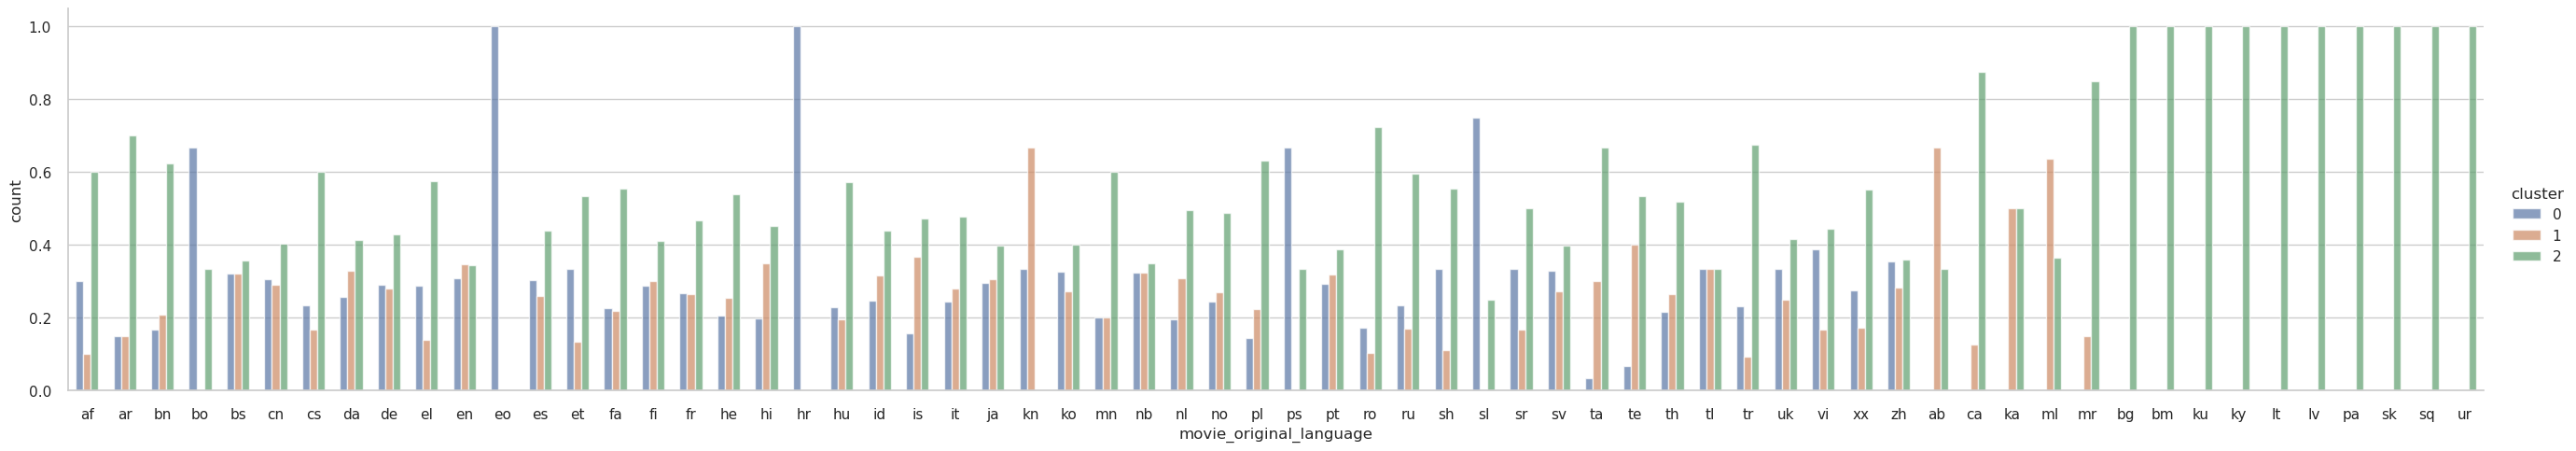

In [343]:
df = data1 \
    .pipe(get_groups, group_cols=['cluster', 'movie_original_language']) \
    .pipe(norm, group_cols='movie_original_language', norm_col='count')

div_bar_plot(
    df,
    x='cluster',
    hue='movie_original_language',
    aspect = 3, height=8, width=0.9
)

div_bar_plot(
    df,
    x='movie_original_language',
    hue='cluster',
    aspect = 5.4, height=5, width=0.6
)